```{contents}
:local:
:depth: 2
```

# Non-parametric Models

## Learning Objectives

After working through this topic, you should be able to:

- Distinguish between parametric and non-parametric regression models
- Identify features, parameters, and hyperparameters in a regression problem
- Implement piecewise linear interpolation as a non-parametric regression model
- Apply kernel regression using radial basis functions and adjust kernel width
- Compare spline models to other non-parametric techniques using scikit-learn

## A Machine-Learning Perspective on Regression

In this section, we introduce the terminology used throughout the rest of this unit. These concepts apply to both simple regression models and more advanced machine learning techniques that we will explore later. Our focus here is on understanding the vocabulary: what do we mean by inputs, outputs, parameters, hyperparameters, features, and models?

The goal of regression is to find a function  

$$
\vec{y} = f(\vec{x}) + \vec{\epsilon}
$$

where $f$ is the model, $x$ is the model input, $y$ is the model output, and $\epsilon$ is the error between the model and the data. The model inputs, $\vec{x}$, are often called the **features** of a data point. In the previous example, we created features using transformations of $x$ like polynomials and Gaussian functions. Sometimes, features may also be given in the dataset (e.g. multiple inputs correspond to a single output). Other times, the model input may be data that does not have obvious vector-based features (e.g. images, audio, molecules, etc.). In this case, we can think of the features as "fingerprints" of some more complex raw input data.

Of course, representing the model as $f$ is a gross oversimplification. The function must have some form, and it usually requires **parameters**. Previously we considered general linear regression models of the form:

$$
y_i = \sum_j w_j X_{ij} + \epsilon_i
$$

where the **parameters** are given by $\vec{w}$. We also considered non-linear regression with Gaussian functions, which required more parameters, $\vec{w}$, $\vec{\mu}$, and $\vec{\sigma}$. We saw that in order to optimize these parameters we had to put them into a single vector. We could consider this to be a parameter vector, $\vec{\lambda} = [\vec{w}, \vec{\mu}, \vec{\sigma}]$, and re-write the model more generally as:

$$
\vec{y} = f(\vec{x}, \vec{\lambda}) + \vec{\epsilon}
$$

We also had to decide how many functions to include in the model (e.g., number of polynomial terms or Gaussian basis functions). This determines the number of parameters, and is referred to as a **hyperparameter** because it controls the overall model complexity. Hyperparameters control the complexity of the final model, and the parameters will depend on the hyperparameters, so we can think of the parameters as being a function of the hyperparameters, $\vec{\lambda}(\vec{\eta})$. If we put all this together we get a model form of:

$$
\vec{y} = f(\vec{x}, \vec{\lambda}(\vec{\eta})) + \vec{\epsilon}
$$

Machine learning differs from regular regression in that it seeks to optimize $\vec{\lambda}$ (parameter optimization), $\vec{\eta}$ (complexity optimization) in order to **obtain a model that generalizes to new input data**. Machine learning also sometimes involves selecting $\vec{x}$ (feature selection) or generating $\vec{x}$ from non-vectorized data such as text or images (feature generation).

```{admonition} Exercise
:class: tip

**Identify the features, parameters, and hyperparameters in a common regression model.**

Consider a polynomial regression model of the form:

$$
y = w_0 + w_1 x + w_2 x^2
$$

1. What is the **feature vector** $\vec{x}$ in this model?
2. What are the **parameters** $\vec{w}$ that must be learned from data?
3. If we decide to use a cubic polynomial instead (adding a $w_3 x^3$ term), what quantity has changed? Is this a parameter or a hyperparameter?

_Tip: Remember that features describe the input, parameters are learned from data, and hyperparameters are set by the user before training._
```

## Non-Parametric Models


We covered the basic math behind parameter optimization in the numerical methods module. The basic idea is to follow two steps:

* Construct a loss function that quantifies how well your model fits the data
* Minimize the loss function with respect to the model parameters

The loss function itself could be the sum of squared errors, some other measure of error (e.g. absolute value of error), and can also contain constraints on the parameters themselves (e.g. force parameters to be positive).

Minimizing the loss function can be achieved analytically in the case of general linear models, or numerically for non-linear models. Moving forward we will typically default to numerical optimization.

In this section we will explore another aspect of model parameters by looking at a new class of models called "non-parameteric" models. The math of parameter optimization is the same, but the way the parameters are defined is different.


### Parametric vs. Non-Parametric Models

A "parametric" model has parameters that do not explicitly depend on or include the input points. The polynomial regression model is an example of a parametric model. The number of parameters is fixed with respect to the number of data points.

A "non-parametric" model includes parameters that are defined on the domain of the independent variables and depend on the inputs. A spline model is an example of a non-parametric model. The number of parameters in the model varies with the number of data points.

Nonparametric models are generally excellent for interpolation, but fail miserably for extrapolation, while parametric models are less accurate for interpolation but provide more reasonable extrapolations. Nonparametric models tend to have many more parameters, and proper optimization of model complexity can lead to similar performance for both types.

See [this post](https://machinelearningmastery.com/parametric-and-nonparametric-machine-learning-algorithms/) for more information.


### Linear Interpolation

To introduce non-parametric models, we will start with linear interpolation. There are much more intuitive and convenient ways to linearly interpolate, but here we will present it in a way that is meant to provide a conceptual bridge between standard linear regression and non-parametric modeling. 

In ordinary linear regression we pick a **fixed, global** set of basis functions (e.g., $1, x, x^2$) and fit a **small, fixed** number of coefficients—this is *parametric*. With linear interpolation we keep the *same linear-in-parameters machinery* and least-squares viewpoint, but switch the basis to **piecewise-linear “hinge” functions** anchored at the observed inputs:

$$
X_{ij}=\max(0,\,x_i-x_j),
$$
plus a constant intercept term. Fitting coefficients for these features yields a model that passes through all data points, since the number of parameters is equal to the number of data points. Because the number of basis functions (and therefore parameters) **grows with the data**, this is *non-parametric*.

This perspective shows that the optimization and diagnostics you know from linear regression still apply—the only change is the design matrix. It also previews more flexible non-parametric methods that we will explore next, such as non-linear radial basis function kernels for smoother interpolation and regularization techniques that help trade off between interpolation and extrapolation.


To demonstrate linear interpolation, we can revisit the spectra dataset that we worked with during the last module:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('../settings/plot_style.mplstyle')

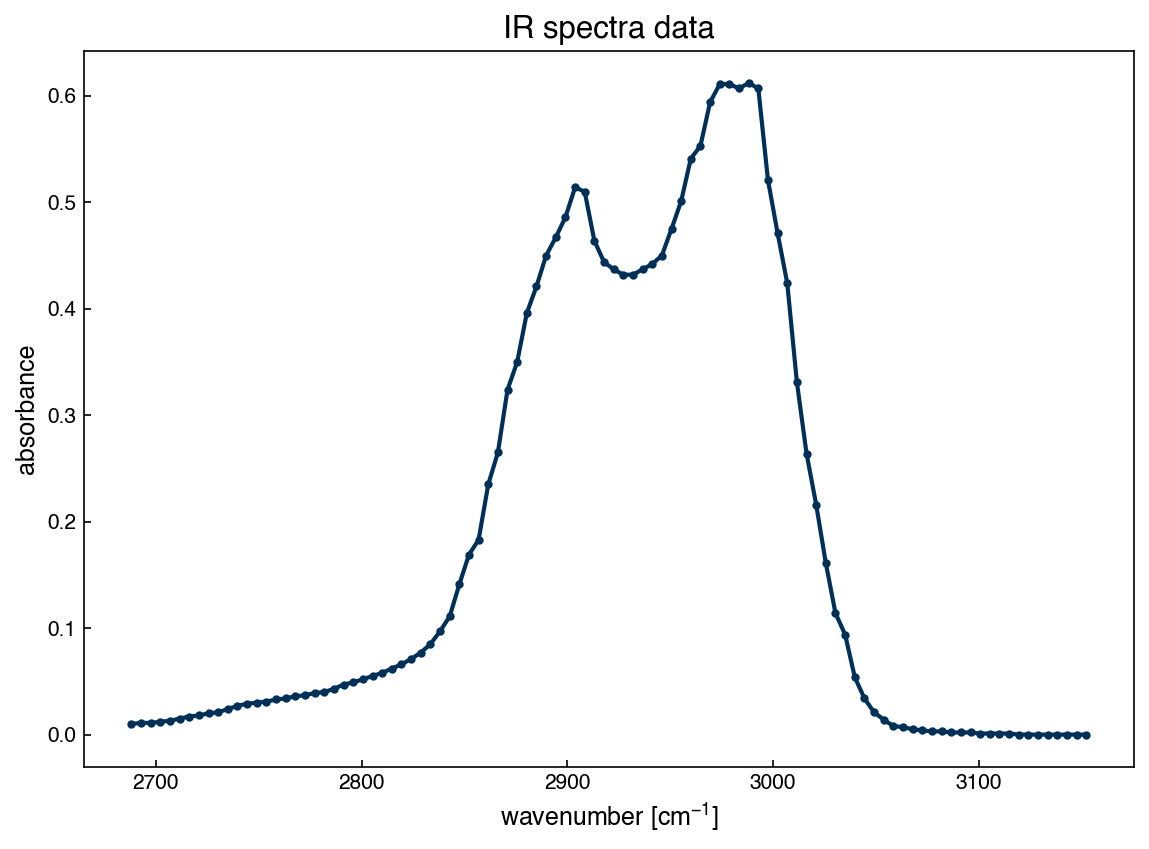

In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv('data/ethanol_IR.csv')
x_all = df['wavenumber [cm^-1]'].values
y_all = df['absorbance'].values

x_peak = x_all[475:575]
y_peak = y_all[475:575]

fig, ax = plt.subplots()
ax.plot(x_peak,y_peak, '-', marker='.')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance')
ax.set_title('IR spectra data');

The goal here is to linearly interpolate between each point with a straight line, and we want to solve this using the machinery of linear regression that we have already seen. The key is to use a basis of "piecewise linear" functions (often called "hinge" functions):

$X_{ij} = max(0, x_i-x_j)$

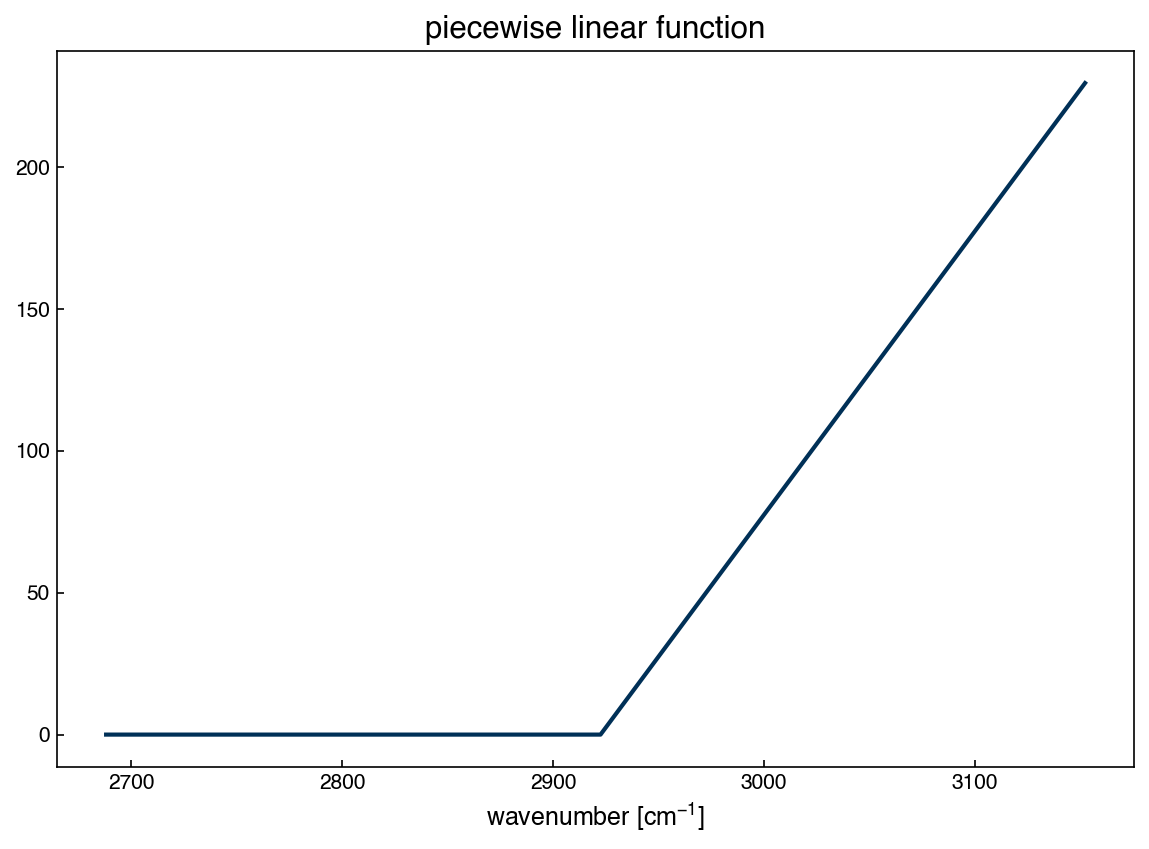

In [3]:
def piecewise_linear(x):
    N = len(x)
    X = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            X[i,j] = max(0, x[i] - x[j])
    return X
            
X = piecewise_linear(x_peak)

fig, ax = plt.subplots()
ax.plot(x_peak, X[:,50], '-')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_title('piecewise linear function');

There is one technical detail here, since the final column will actually just be 0:

In [4]:
X[:,-1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Clearly, this cannot contribute to the model. We can make it a column of 1's instead, so that it acts like an intercept term:

In [5]:
X[:,-1] += 1
X[:, -1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

This trick of adding an intercept with a column of 1's (or any constant) is one we will use throughout the course. Conceptually, it is a little tricky to understand at first, but it makes the math cleaner (although it is mathematically identical to adding a simple constant intercept).

Now let's visualize all of the basis functions:

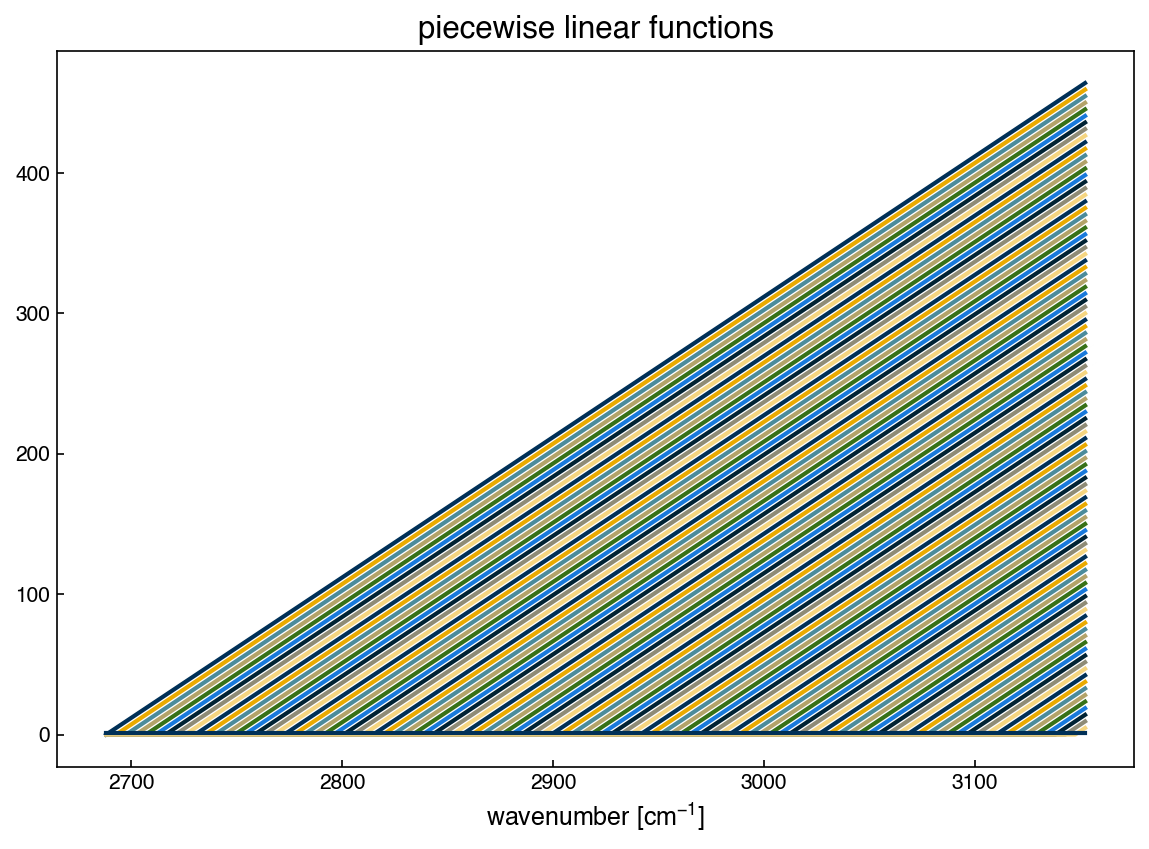

In [6]:
fig, ax = plt.subplots()
for i in range(len(x_peak)):
    ax.plot(x_peak, X[:,i], '-')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_title('piecewise linear functions');

Our basis set, or "features", consist of straight lines with slope 1 that originate at each data point. Now we can achieve linear interpolation by solving the general linear regression problem. We will use `scikit-learn` to make this easy, but you can verify the solution using the equations from the foundations module if you want:

r^2 = 1.0


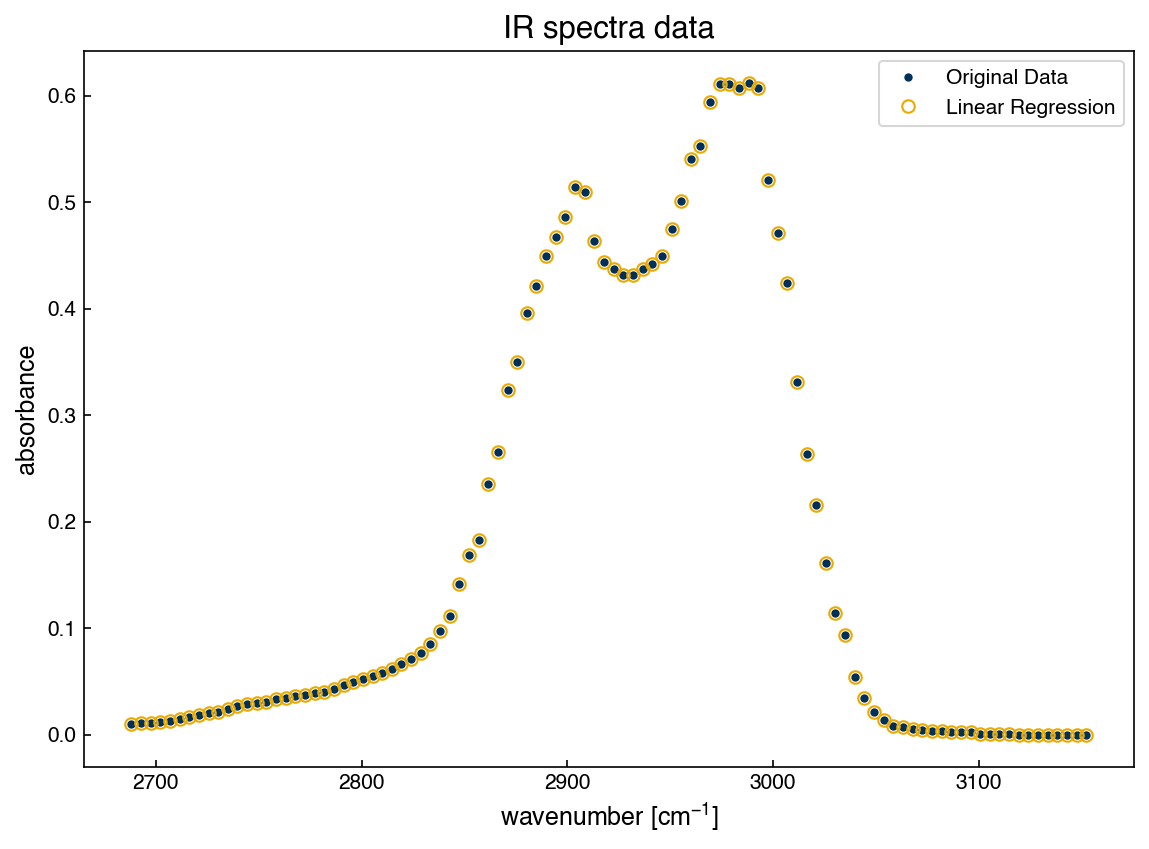

In [7]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False) #create a linear regression model instance (no intercept needed)
model.fit(X, y_peak) #fit the model
r2 = model.score(X, y_peak) #get the "score", which is equivalent to r^2

yhat = model.predict(X) #create the model prediction

fig, ax = plt.subplots()
ax.plot(x_peak, y_peak, '.')
ax.plot(x_peak, yhat, 'o', markerfacecolor='none')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance')
ax.set_title('IR spectra data')
ax.legend(['Original Data', 'Linear Regression'])
print('r^2 = {}'.format(r2))

```{admonition}
:class: note

What is in the column space of the design matrix? Why do we set `fit_intercept=False`?

The column space, or "features" of the design matrix" are the hinge functions, with one column for each data point in the original dataset. We set `fit_intercept = False` because we have already added a column of 1's at the end of the matrix, which acts as an intercept. Removing the last column and setting `fit_intercept=True` would yield the same results.
```

We can see that the model goes through every point exactly, which we should know from $r^2=1$. However, we don't actually know what the model is doing in between the points. For this we need to predict on a new set of $x$ points that has a higher resolution:

In [8]:
x_predict = np.linspace(2650, 3150, 1000)
X_predict = piecewise_linear(x_predict)

This brings up an important conceptual problem: we cannot directly predict on the new dataset because the dimensions of the matrices do not match. The column space acts as a basis set for regression, and when we trained the model we had 100 "features" (one for each data point). However, our new X matrix has 500 columns, which is a different set of "features" than the 100 that we trained on originally. **If we want to make predictions we need to expand the row space while keeping the column space constant**.

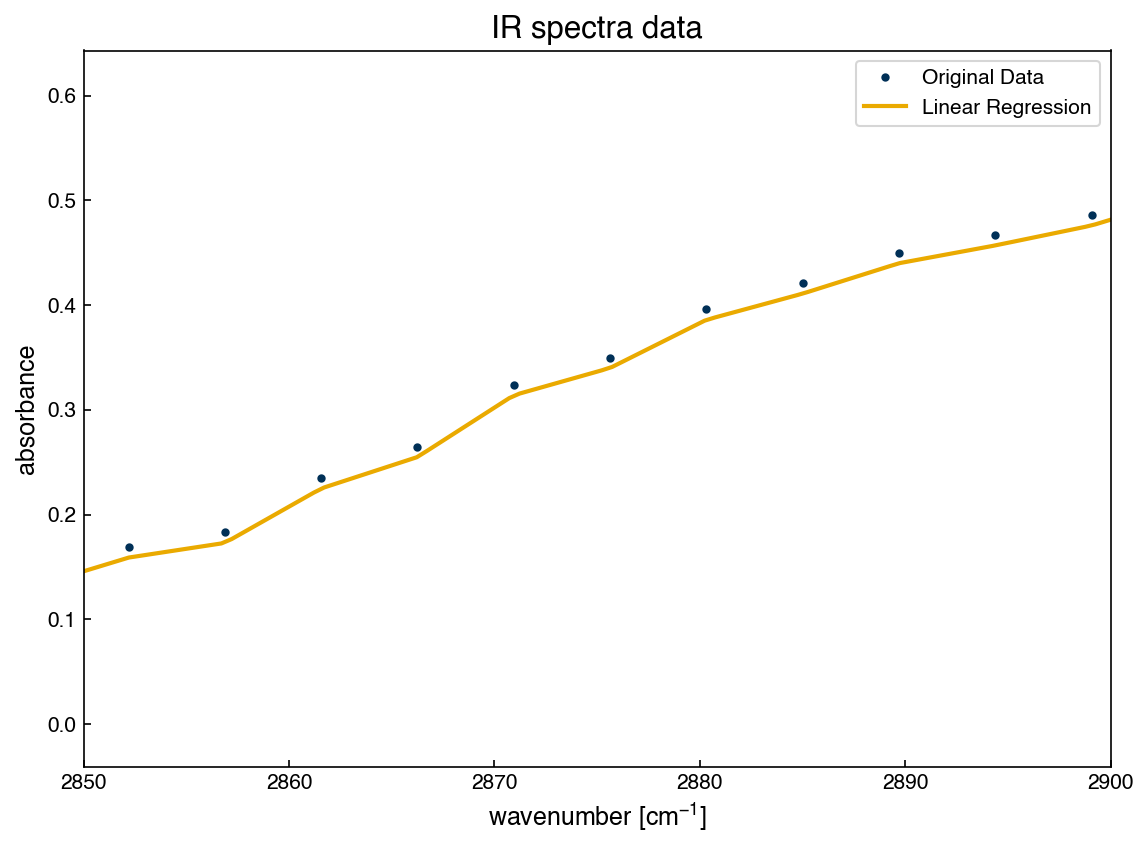

r^2 = 1.0


In [9]:
def piecewise_linear(x_train, x_test=None):
    if x_test is None:
        x_test = x_train
    N = len(x_test) #<- number of data points
    M = len(x_train) #<- number of features
    X = np.zeros((N,M))
    for i in range(N):
        for j in range(M):
            X[i,j] = max(0, x_test[i] - x_train[j])
    return X

X_predict = piecewise_linear(x_peak, x_predict)
yhat_predict = model.predict(X_predict)

r2 = model.score(X, y_peak)

fig, ax = plt.subplots()
ax.plot(x_peak, y_peak, '.')
ax.plot(x_predict, yhat_predict, '-', markerfacecolor='none')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance')
ax.set_title('IR spectra data')
ax.legend(['Original Data', 'Linear Regression'])
ax.set_xlim([2850, 2900])
plt.show()
print('r^2 = {}'.format(r2))

We see that the model successful at interpolating between the points. This is an example of a **non-parametric** model. The number of parameters, $\vec{w}$ is equal to the number of **training** data points, and the number of columns in the linear design matrix. The number of rows is equal to the number of data points that the model will predict. These numbers do not need to be equal, and it is not necessary that the training points are included in the prediction.

```{admonition} Exercise
:class: tip

Use every third data point of the spectra dataset to train a linear interpolation model and explore the predictions.

1. Select every third datapoint from the `(x_peak, y_peak)` dataset, and use this to train a linear interpolation model. 
2. Predict the full dataset using the model and compare the predictions to the original data.
3. Create a new high-resolution prediction set with a total of 300 evenly-spaced points. Compare these predictions to those of the full dataset.
4. Create another prediction dataset with 300 evenly-spaced points with the minimum and maximum being 10 wavenumbers above/below the original maximum. This shows how the model performs when asked to extrapolate.
```


## Kernel Regression

Of course, we are not limited to using piecewise linear functions in non-parametric models. In fact, this is rarely done in practice, since there are easier ways to do linear interpolation. However, using the same mathematical machinery we can take a more general and powerful approach using the idea of a **kernel** function. In machine learning, a kernel is a function that describes the **similarity** between two input points. We use this to define a new type of regression model that places **smooth, localized bumps** (called **basis functions**) at each training point.

A kernel takes the form:

$$
K(i, j) = f(x_i, x_j)
$$

where $ f $ is some function of two inputs. Formally, any function that is symmetric ( $K(i,j) = K(j,i) $) and "positive semi-definite" (i.e. all entries are zero or positive) can serve as a kernel. There are many common kernels, such as the polynomial kernel,  the Laplacian/exponential kernel, or the periodic kernel, and the [kernel cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/) is a good resource for learning more about these standard kernels and how to combine them. However, the most commonly used kernel is the **radial basis function** (RBF) or **Gaussian kernel**, which is the one we will focus on in this course. It is defined by:

$$
\text{rbf}(i, j) = \exp\left(-\gamma (x_i - x_j)^2\right)
$$

This function is largest when $ x_i \approx x_j $ and quickly decays to zero as the two inputs become more distant. You can think of it as placing a **smooth bump** centered at every training point $ x_j $, and the height of each bump at test point $ x_i $ depends on how close $ x_i $ is to $ x_j $.

If you look closely, this is just the standard Gaussian function:

$$
G(x_i) = \exp\left(-\frac{(x_i - \mu)^2}{2\sigma^2}\right)
$$

with $ \mu = x_j $ and $ \gamma = \frac{1}{2\sigma^2} $. That means we can use the Gaussian width $ \sigma $ to tune how wide each bump is, or equivalently use $ \gamma $ to control how rapidly the kernel decays.


---

### Visualizing the Basis Functions

Let’s start by defining a function to build the radial basis design matrix:

In [10]:
def rbf(x_train, x_test=None, gamma=1):
    if x_test is None:
        x_test = x_train
    N = len(x_test)
    M = len(x_train)
    X = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            X[i, j] = np.exp(-gamma * (x_test[i] - x_train[j])**2)
    return X

Now we can explore how the RBF basis looks for a specific value of $ \sigma $:

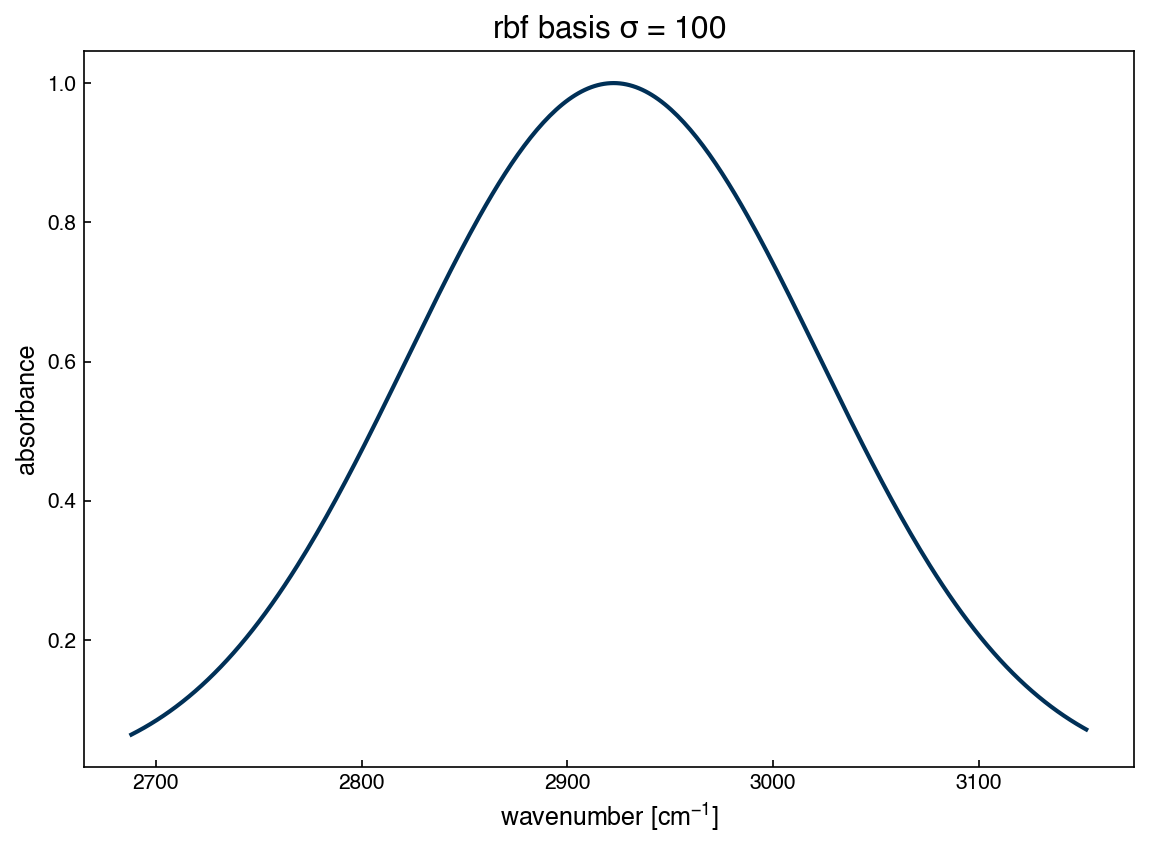

In [11]:
sigma = 100
gamma = 1. / (2 * sigma**2)
x_test = np.linspace(min(x_peak), max(x_peak), 300)
X_rbf = rbf(x_peak, x_test=x_test, gamma=gamma)

fig, ax = plt.subplots()
ax.plot(x_test, X_rbf[:, 50], '-')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance')
ax.set_title('rbf basis $\sigma$ = {}'.format(str(sigma)));

---

### Fitting a Kernel Regression Model

Let’s use this basis to build a regression model just like we did with linear interpolation:

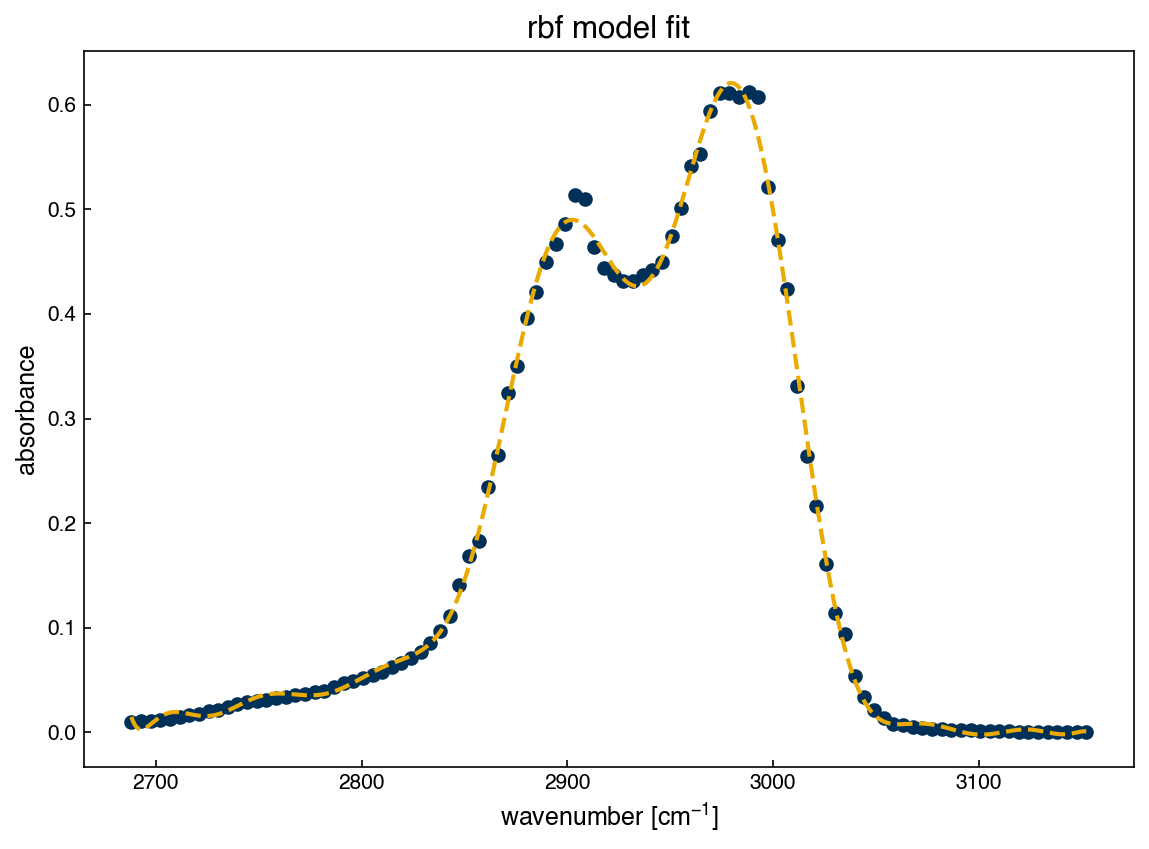

In [12]:
X_train = rbf(x_peak, gamma=gamma)
xx = np.linspace(min(x_peak), max(x_peak), 500)

model_rbf = LinearRegression(fit_intercept=False)
model_rbf.fit(X_train, y_peak)

X_eval = rbf(x_peak, x_test=xx, gamma=gamma)
y_eval = model_rbf.predict(X_eval)

fig, ax = plt.subplots()
ax.plot(x_peak, y_peak, 'o')
ax.plot(xx, y_eval, '--')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance')
ax.set_title('rbf model fit');

```{note}
What happens when the kernel is too wide or too narrow?

- If the kernel is **too wide** (large $\sigma$ , small $\gamma$ ), then each basis function overlaps many others. The model becomes overly smooth and may underfit the data.
- If the kernel is **too narrow** (small $ \sigma $, large $ \gamma $), then each basis function only affects a tiny region, and the model can overfit the data and become unstable.
- A good kernel regression model requires choosing an appropriate **kernel width**, much like choosing the degree of a polynomial.
```

Let's try several different kernel widths and observe how they affect the smoothness and flexibility of the model. For this demonstration, we will use:

- $ \sigma = 25 $
- $ \sigma = 50 $
- $ \sigma = 100 $

Here, we keep the same training data and model setup, and compare the resulting model fits.

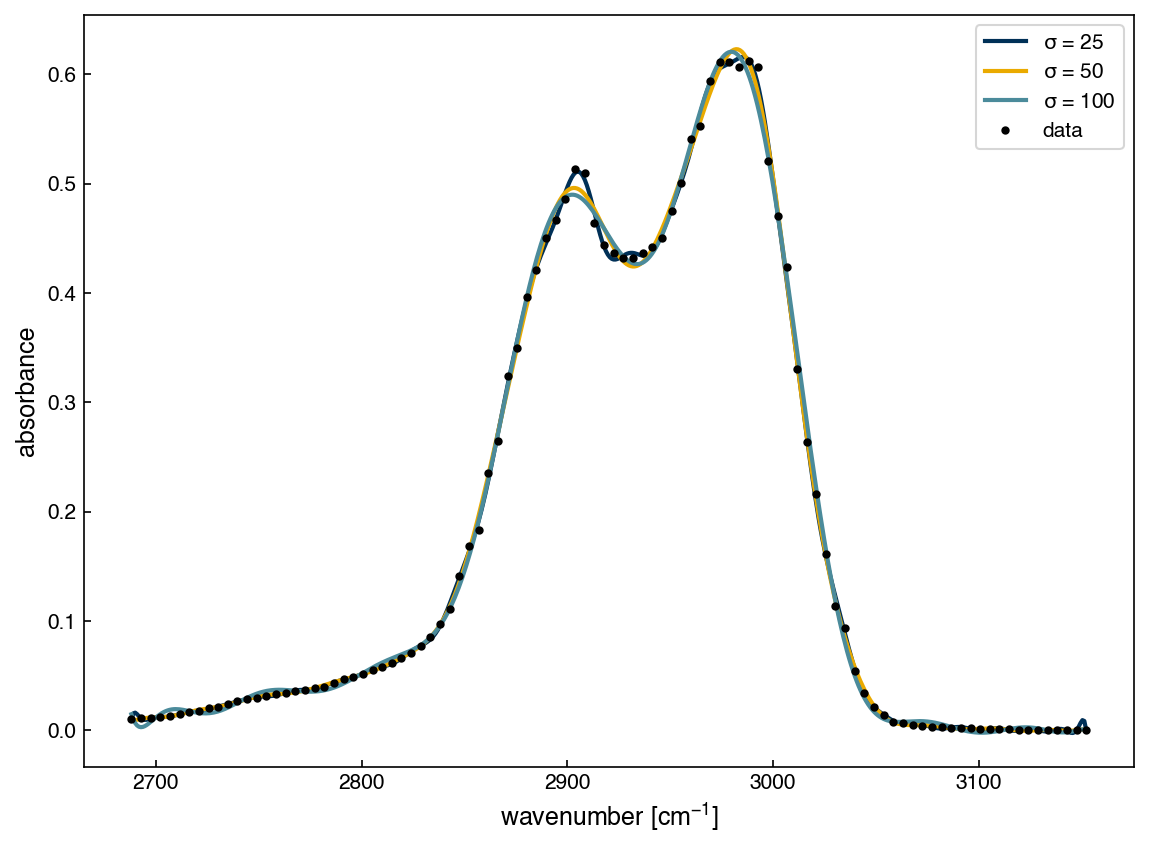

In [13]:
sigmas = [25, 50, 100]
fig, ax = plt.subplots()

for sigma in sigmas:
    gamma = 1. / (2 * sigma**2)
    X_train = rbf(x_peak, gamma=gamma)
    model_rbf = LinearRegression(fit_intercept=False)
    model_rbf.fit(X_train, y_peak)

    X_eval = rbf(x_peak, x_test=xx, gamma=gamma)
    y_eval = model_rbf.predict(X_eval)

    ax.plot(xx, y_eval, label=f"$\sigma$ = {sigma}")

ax.plot(x_peak, y_peak, 'k.', label='data')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance')
ax.legend();

---

```{admonition} Exercise
:class: tip

Explore how the **number of training points** affects the model fit.

- Fix $ \sigma = 50 $
- Try using every 5th, every 3rd, and all available data points as your training set
- Compare the fitted curves and comment on the impact of data density

This exercise helps illustrate the **tradeoff between data quantity and model complexity** in non-parametric regression.
```

## Other Non-Parametric Regression Models

In previous sections, we explored two important types of non-parametric models for regression:

- **Linear interpolation**, where the model constructs piecewise linear functions based directly on the data points
- **Kernel regression**, which fits smooth functions by applying a local Gaussian-like influence from each data point

These are both examples of **instance-based models**, where the complexity of the model grows with the number of training points. Many other regression techniques share this non-parametric character — they do not assume a fixed functional form with a predetermined number of parameters. Instead, the model structure adapts to the data.

Here are a few additional families of non-parametric regression models:

- **Spline models**: Use piecewise polynomials joined at “knots” with continuity and smoothness constraints (e.g., cubic splines).
- **Gaussian Process Regression (GPR)**: Places a prior over functions using a kernel and produces a posterior predictive distribution. This is a probabilistic model with built-in uncertainty quantification.
- **Locally weighted regression (LOWESS/LOESS)**: Uses local weighted least-squares fits in a moving window across the input domain.

All of these methods provide flexible tools for regression, particularly when the true underlying function is complex or not well represented by a simple parametric form.

---

### Example: Spline Regression

Splines are an elegant extension of piecewise polynomial interpolation. They combine flexibility with smoothness by connecting low-degree polynomials at **knot points**. In this example, we’ll use a cubic spline model implemented via `scikit-learn`'s `SplineTransformer` along with linear regression.

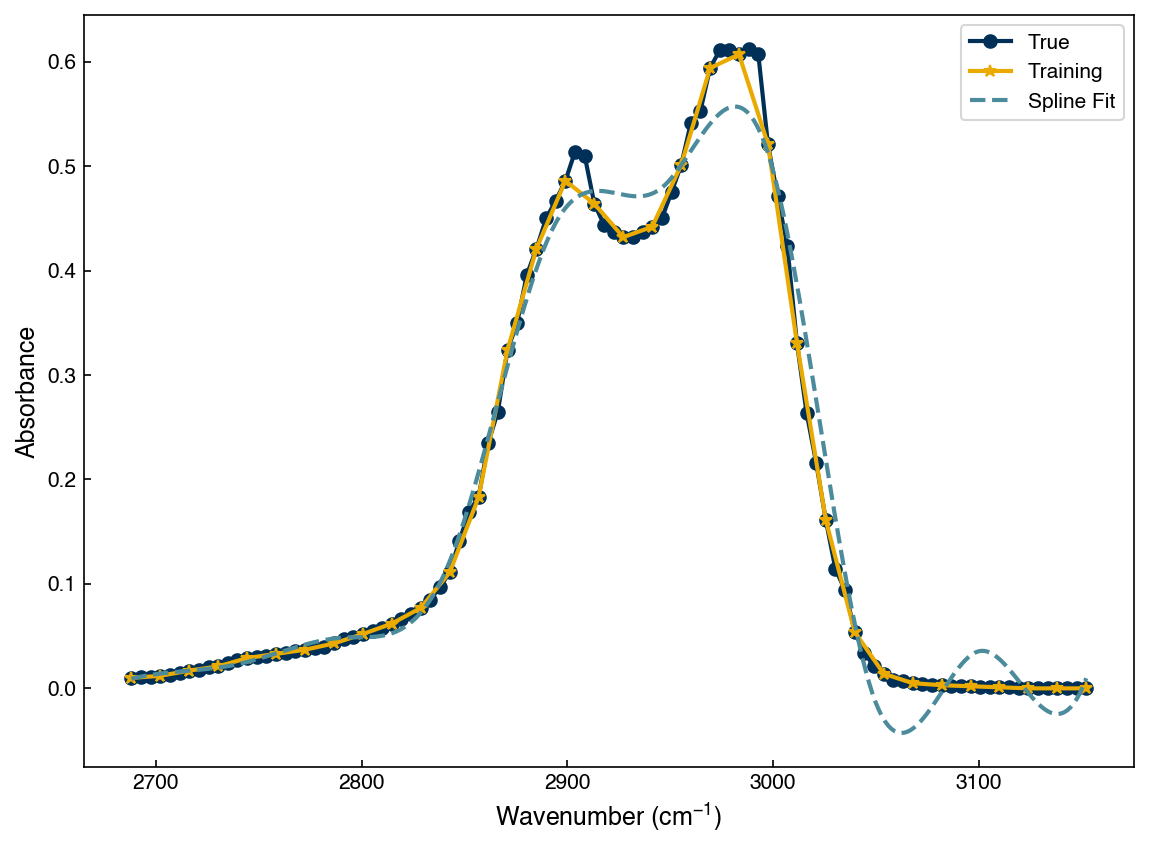

In [14]:
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline

# Use every third point for training
x_train = x_peak[::3].reshape(-1, 1)
y_train = y_peak[::3]

# Use a spline transformer with 10 knots and cubic polynomials
spline_model = make_pipeline(
    SplineTransformer(degree=3, n_knots=10, include_bias=False),
    LinearRegression()
)
spline_model.fit(x_train, y_train)

# Evaluate on the full domain
x_eval = np.linspace(min(x_peak), max(x_peak), 300).reshape(-1,1)
y_pred = spline_model.predict(x_eval)

# Plot the result
fig, ax = plt.subplots()
ax.plot(x_peak, y_peak, label='True',marker='o')
ax.plot(x_train, y_train, label='Training', marker='*')
ax.plot(x_eval, y_pred, '--', label='Spline Fit')
ax.set_xlabel('Wavenumber (cm$^{-1}$)')
ax.set_ylabel('Absorbance')
ax.legend();

---

This spline model behaves similarly to kernel regression: it interpolates smoothly between training points while controlling flexibility through the **number of knots** and **polynomial degree**. It is often more stable than interpolation, and more interpretable than kernel methods when used with fixed knot locations.

---

```{admonition} Exercise
:class: tip

Explore the effect of **spline hyperparameters** on model flexibility:

- Try changing the number of knots (e.g., `n_knots=5`, `n_knots=20`)
- Try using lower or higher-degree polynomials (e.g., `degree=2` or `degree=4`)
- Use a fixed training set (e.g., every third point)

Plot the resulting fits and describe how the **number of knots** and **polynomial degree** affect the smoothness and flexibility of the spline model.
```

## Additional Reading

- [Parametric vs. Nonparametric Models](https://machinelearningmastery.com/parametric-and-nonparametric-machine-learning-algorithms/) — A brief introduction highlighting key differences and examples  
- [Kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/) - Details on different types of kernels and how to combine them.
- Hastie, Tibshirani, and Friedman. *The Elements of Statistical Learning*, Chapter 3: “Linear Methods for Regression”. Springer. [Available online](https://hastie.su.domains/ElemStatLearn/)  
- [Nonparametric Regression: Concepts, Models, and Techniques](https://sebastianraschka.com/blog/2020/model-evaluation-selection-part2.html) by Sebastian Raschka — An intuitive and detailed blog post covering kernel regression, local models, and model complexity tradeoffs